# Writing a modal solver #


In [1]:
from fenics import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

Reference problem is the linear Poisson equation. We compute the solution to this using a linear solver for reference.

In [2]:
def linear_solve(a, L, uh, bc): 
    A = assemble(a)
    b = assemble(L) 
    bc.apply(A, b) 
    x = uh.vector() 
    solve(A, x, b)
    return x

The linear solver is applied on the Poisson equation and we get the same result as above:

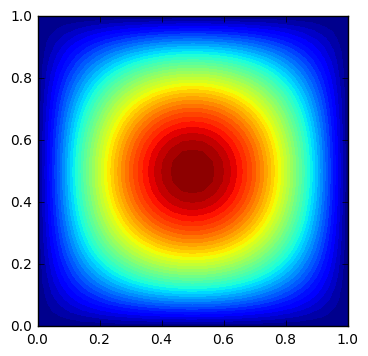

In [3]:
h = 32
mesh = UnitSquareMesh(h, h)   # generate mesh
V = FunctionSpace(mesh, 'P', 1)    # create finite element function space V, based on linear Lagrange elements
# plot(mesh)

f_exp = Expression('2*pi*pi * sin(pi*x[0]) * sin(pi*x[1])', degree=4)

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary

# Define boundary conditions
u_D = Expression('sin(pi*x[0]) * sin(pi*x[1])', degree=4)
bc = DirichletBC(V, u_D, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

# Compute solution
uref = Function(V)
uref.vector()[:] = linear_solve(a, L, uref, bc)
plot(uref)
plt.show()

#### Compare to reference solution ####
In the current case we are looking at a static problem, therefore we only use the stiffness matrix K in our analysis. This leads to the following problem on the modal basis:

$$
\mathbf{K}_m \mathbf{c}_n = \mathbf{f}_m
$$

Which can easily be solved by 
$$
\mathbf{c}_n = \mathbf{K}_m^{-1} \mathbf{f}_m
$$

We will now try to find the modes based on the Jacobian in this notebook.

In [4]:
def extract_modes(A, neigs):
    solver = SLEPcEigenSolver(A)
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = 0.
    solver.solve(neigs)
    
    # Extract and plot modes
    modes=[]
    eigvalues=[]
    vtkfile = File('Modes/modes.pvd')  
    for md in range(neigs):
        r, c, rx, cx = solver.get_eigenpair(md)
        # Initialize function and assign eigenvector
        if not (r > 1.-1.e-8 and r < 1.+1.e-8):    # filter out spurious eigenvectors
            mode = Function(V)
            mode.rename("mode",'mode')
            mode.vector()[:] = rx
            modes.append(mode)
            eigvalues.append(r)
            # Save mode to file
            vtkfile << (mode, r)    
            del(mode)
    return modes, eigvalues

# Static coefficient solver
def x_stat(K, F):
    return np.dot(np.linalg.inv(K), F)

In [5]:
def L_func(v):
    return f_exp * v * dx

def a_func(u, v):
    return inner(grad(u), grad(v))*dx

### Modal analysis using stiffness matrices ###
The "stiffness" of the problem is given as the matrix $\mathbf{A}$ that is calculated over the domain using a function that integrates over the domain. This way the modal stiffness matrix of the domain is contructed using the mode shapes directly.

The problem is solved by:
* assembling the system in a PETSc matrix
* extracting the eigenpairs of the left hand side
* construction of modal "stiffness" and force matrix
* the solution is found by a linear algebra solution algorithm

('Time: ', 0.09207010269165039)


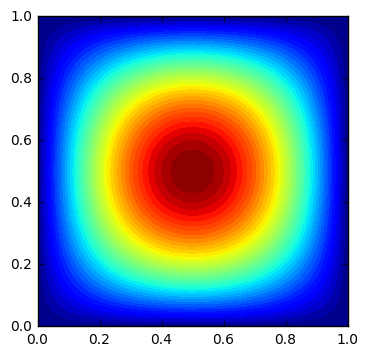

In [6]:

# Define modal variational problem
u = TrialFunction(V)
v = TestFunction(V)

a = a_func(u, v)
L = L_func(v)

# Get eigenvalues, modes and coefficients (should be rewritten for dynamic case)
neigs=10
uh = Function(V)

# set up matrices and assemble systen
A = PETScMatrix()
b = PETScVector()
assemble_system(a, L, bc, A_tensor=A, b_tensor=b)

# Extract modes and set up modal matrices
modes, evs = extract_modes(A, neigs)
nmodes = len(evs)
M1 = np.zeros([nmodes,nmodes])
K1 = np.zeros([nmodes,nmodes])
F1 = np.zeros(nmodes)

# Project problem on modal basis
for i in range(nmodes):
    F1[i] = assemble(L_func(modes[i]))
    for j in range(nmodes):
        K1[i,j]= assemble(a_func(modes[i], modes[j]))

start = time.time()
# Calculate the static coefficients
c_0 = np.linalg.solve(K1, F1)
uh = c_0[0]*modes[0]
plot(uh)
print("Time: ", time.time() - start)

### second modal solver ###
The problem can be solved using only the PETSc matrix (and therefore no construction functions) as well:

The problem is solved by:
* assembling the system in a PETSc matrix
* extracting the eigenpairs of the left hand side
* projecting the PETSc matrix on a modal basis by multiplication
* the solution is found by a premultiplying both sides by the inverted modal stiffness $
\mathbf{c}_n = \mathbf{K}_m^{-1} \mathbf{f}_m $

This solver seems to be faster than reconstructing the stiffness and force matrices, also the operations are closer to the actual math it is based on. 

0.364361047745


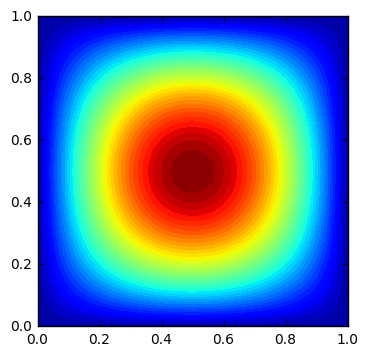

In [7]:
start = time.time()
# Define modal variational problem
u = TrialFunction(V)
v = TestFunction(V)

a = a_func(u, v)
L = L_func(v)

# Get eigenvalues, modes and coefficients (should be rewritten for dynamic case)
neigs=10
uh = Function(V)

# set up matrices and assemble systen
A = PETScMatrix()
b = PETScVector()
assemble_system(a, L, bc, A_tensor=A, b_tensor=b)

# Extract modes and set up modal matrices
modes, evs = extract_modes(A, neigs)
nmodes = len(evs)

l_vec = len(modes[0].vector().array())
mode_array = np.zeros((l_vec, nmodes))
for i in range(nmodes):
    mode_array[:, i] = modes[i].vector().array()

F = np.dot(mode_array.T, b.array())
K = np.dot(np.dot(mode_array.T, A.array()), mode_array)

# Calculate the static coefficients
c_0 = np.linalg.solve(K, F)
uh = c_0[0]*modes[0]
plot(uh)
print(time.time() - start)

In [8]:
# To prove that the above are practically the same methods:
np.linalg.norm(K1 - K)

1.4943377186710883e-10

Some spurious eigenvectors may exist because the boundary conditions are defined by setting the row and column where the Dirichlet boundary conditions are defined equal to zero and a 1 is set on the diagonal (as far as I understood).

## Modal solver

The above script is rewritten so that next time we only need to call our modal solver to calculate the modal solution.

In [9]:
# Modal solver
def modal_solve(a, L, uh, bc, neigs): 
    A = PETScMatrix()
    b = PETScVector()
    assemble_system(a, L, bc, A_tensor=A, b_tensor=b)
    modes, evs = extract_modes(A, neigs)
    nmodes = len(evs)
    l_vec = len(modes[0].vector().array())
    mode_array = np.zeros((l_vec, nmodes))
    for i in range(nmodes):
        mode_array[:, i] = modes[i].vector().array()
    F = np.dot(mode_array.T, b.array())
    K = np.dot(np.dot(mode_array.T, A.array()), mode_array)
    c_0 = np.linalg.solve(K, F)
    return c_0, modes, evs

### Using the modal solver ####
To apply the modal solver everything stays the same as before except that now we use the modal solver function instead of writing out the calculation.

In [10]:
# Solve the problem using modal solver
neigs=10
uh = Function(V)
c_0, modes, evs = modal_solve(a, L, uh, bc, neigs)

uh = c_0[0]*modes[0]

Modal sum of displacement with 10 modes compared to reference solution


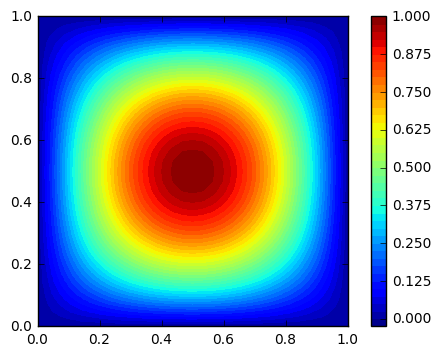

Difference between direct and modal solution


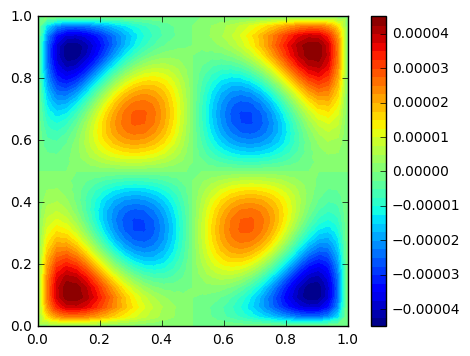

In [11]:
fig = plt.figure()
ttl="Modal sum of displacement with " + str(len(evs)) + " modes compared to reference solution"
modes_total = sum(c_0[:]*modes[:])
print(ttl)
ax1 = plot(modes_total)
cbar = plt.colorbar(ax1)
plt.show()

print("Difference between direct and modal solution")
ax = plot(uref - modes_total)
cbar = plt.colorbar(ax)
plt.show()

In [12]:
u = TrialFunction(V)
v = TestFunction(V)

a = inner(grad(u), grad(v))*dx
L = f_exp * v * dx

neigs = 2**5
# Compute solution
uh = Function(V)
c_0, modes, evs = modal_solve(a, L, uh, bc, neigs)

uh = c_0[0]*modes[0]

Modal sum of displacement with 32 modes compared to reference solution


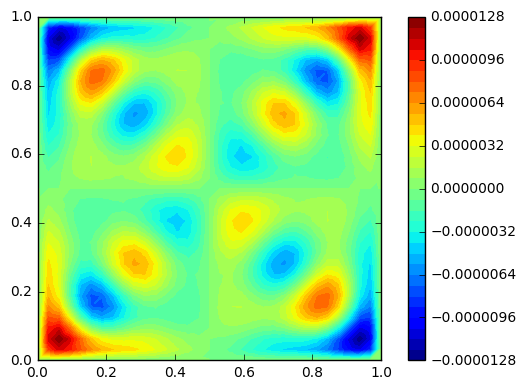

In [13]:
fig = plt.figure()
print("Modal sum of displacement with " + str(len(evs)) + " modes compared to reference solution")
#plt.title(ttl)
modes_total = sum(c_0[:]*modes[:])
ax = plot(uref - modes_total)
cbar = plt.colorbar(ax)
plt.tight_layout()

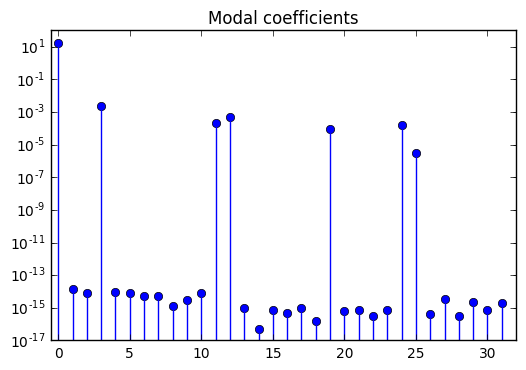

In [14]:
plt.stem(abs(c_0))
plt.title("Modal coefficients")
plt.yscale('log')
plt.xlim([-0.5, neigs])
plt.show()

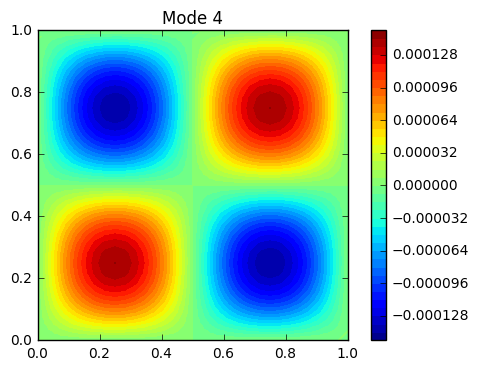

norm of mode 4 relative to norm of reference solution
0.000144372612319


In [15]:
idx = 3
fig = plt.figure()
plt.title("Mode {}".format(idx+1))
ax = plot(c_0[idx]*modes[idx])
cbar = plt.colorbar(ax)
plt.show()

print("norm of mode {} relative to norm of reference solution".format(idx+1))
print(c_0[idx]*modes[idx].vector().norm("l2") / abs(uref.vector()[:].norm("l2")))


In [16]:

nmodes = len(eigvalues)
l_vec = len(modes[0].vector().array())
mode_array = np.zeros((l_vec, nmodes))
for i in range(nmodes):
    mode_array[:, i] = modes[i].vector().array()

NameError: name 'eigvalues' is not defined